In [136]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['Times New Roman']
plt.rcParams['figure.dpi'] = 300
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.colors import LogNorm
from astropy.visualization import SqrtStretch, LinearStretch, LogStretch
from astropy.visualization.mpl_normalize import ImageNormalize
import pandas as pd
import re
from astropy.io import fits
import os

import os
os.chdir("/Users/ainsleylewis/Documents/Astronomy/IllustrisTNG Lens Modelling")

In [199]:
# Model Opening
model_path = 'Test/SIE+SHEAR'
model_ver = 'SIE_POS_SHEAR'
lens_name = f'"{model_path}"'

if 'POS+FLUX' in model_ver:
    constraint = 'pos_flux'
elif 'POS' in model_ver:
    constraint = 'pos'


# Load the data
with open(model_path + '/' + model_ver + '_optresult' + '.dat', 'r') as file:
    opt_result = file.readlines()

opt_result


# with open(model_path + '/' + constraint + '_point' + '.py', 'r') as file:
#     py = file.readlines()

# py

['------------------------------------------\n',
 'optimize ndim=2\n',
 'run 1: 0 lens models calculated\n',
 'chi^2 = 1.258066e+06  [N_data(extend): 0]\n',
 ' extend     : 0.000000e+00 0.000000e+00 0.000000e+00\n',
 ' point no 1 : 1.258066e+06 1.258066e+06 0.000000e+00 0.000000e+00 0.000000e+00\n',
 ' lens prior : 0.000000e+00\n',
 ' map prior  : 0.000000e+00\n',
 '\n',
 'omega = 0.3000  lambda = 0.7000  weos = -1.0000  hubble = 0.7000\n',
 '\n',
 'lens   sie     0.2613  1.300000e+02  2.080000e+01  2.075000e+01  1.070000e-01  2.338000e+01  0.000000e+00  0.000000e+00 \n',
 'lens   pert    0.2613  1.000000e+00  2.090000e+01  2.064000e+01  9.000000e-01  0.000000e+00  0.000000e+00  1.000000e+00 \n',
 'point  1.0000  2.091004e+01  2.076733e+01 \n',
 '------------------------------------------\n']

In [200]:
# Find the last line with 'optimize' in it
last_optimize_index = None
for idx in range(len(opt_result) - 1, -1, -1):
    if 'optimize' in opt_result[idx]:
        last_optimize_index = idx
        last_optimize_line = opt_result[idx]
        break
if last_optimize_index is None:
    raise ValueError("No line with 'optimize' found in the file.")

print(f"Last 'optimize' line found at index: {last_optimize_index}")

# Extract everything after the last 'optimize' line
opt_result = opt_result[last_optimize_index + 1:]

opt_result


Last 'optimize' line found at index: 1


['run 1: 0 lens models calculated\n',
 'chi^2 = 1.258066e+06  [N_data(extend): 0]\n',
 ' extend     : 0.000000e+00 0.000000e+00 0.000000e+00\n',
 ' point no 1 : 1.258066e+06 1.258066e+06 0.000000e+00 0.000000e+00 0.000000e+00\n',
 ' lens prior : 0.000000e+00\n',
 ' map prior  : 0.000000e+00\n',
 '\n',
 'omega = 0.3000  lambda = 0.7000  weos = -1.0000  hubble = 0.7000\n',
 '\n',
 'lens   sie     0.2613  1.300000e+02  2.080000e+01  2.075000e+01  1.070000e-01  2.338000e+01  0.000000e+00  0.000000e+00 \n',
 'lens   pert    0.2613  1.000000e+00  2.090000e+01  2.064000e+01  9.000000e-01  0.000000e+00  0.000000e+00  1.000000e+00 \n',
 'point  1.0000  2.091004e+01  2.076733e+01 \n',
 '------------------------------------------\n']

In [201]:
# Count the number of lines that start with 'lens'
lens_count = sum(1 for line in opt_result if line.startswith('lens'))
print(f"Number of 'lens' lines: {lens_count}")

# Initialize a dictionary to hold the lens parameters
lens_params_dict = {}

# Extract the lens parameters
lens_params = []
for line in opt_result:
    if line.startswith('lens'):
        # Extract the line and split it into parts
        parts = re.split(r'\s+', line.strip())
        print(parts)
        # Extract the lens name and parameters
        lens_name = parts[1]
        params = [float(x) for x in parts[2:]]

        # Store the parameters in the dictionary
        lens_params_dict[lens_name] = params
        lens_params.append((lens_name, params))

# Remove the first lens parameter
if lens_params:
    for i in range(len(lens_params)):
        lens_name, params = lens_params[i]
        lens_params_dict[lens_name] = params[1:]


# Number of len profiles
num_lens_profiles = len(lens_params_dict)
print(f"Number of lens profiles: {num_lens_profiles}")
    
lens_params_dict

Number of 'lens' lines: 2
['lens', 'sie', '0.2613', '1.300000e+02', '2.080000e+01', '2.075000e+01', '1.070000e-01', '2.338000e+01', '0.000000e+00', '0.000000e+00']
['lens', 'pert', '0.2613', '1.000000e+00', '2.090000e+01', '2.064000e+01', '9.000000e-01', '0.000000e+00', '0.000000e+00', '1.000000e+00']
Number of lens profiles: 2


{'sie': [130.0, 20.8, 20.75, 0.107, 23.38, 0.0, 0.0],
 'pert': [1.0, 20.9, 20.64, 0.9, 0.0, 0.0, 1.0]}

In [202]:
# Initialize a dictionary to hold the lens parameters
set_point_dict = {}

# Extract the lens parameters
set_points = []
for line in opt_result:
    if line.startswith('point'):
        # Extract the line and split it into parts
        parts = re.split(r'\s+', line.strip())
        print(parts)

set_point_values = [float(x) for x in parts[1:]]

set_point_values

['point', '1.0000', '2.091004e+01', '2.076733e+01']


[1.0, 20.91004, 20.76733]

In [203]:
# Use generic column names: param1, param2, ...
df = pd.DataFrame()
rows = []
max_param_len = 0

for lens_name, params in lens_params_dict.items():
    row = {'Lens Name': lens_name}
    for i, val in enumerate(params):
        row[f'param{i+1}'] = val
    rows.append(row)
    if len(params) > max_param_len:
        max_param_len = len(params)

columns = ['Lens Name'] + [f'param{i+1}' for i in range(max_param_len)]
df = pd.DataFrame(rows, columns=columns)


In [227]:
df

,Lens Name,param1,param2,param3,param4,param5,param6,param7
0,"""sie""",130.0,20.8,20.75,0.107,23.38,0.0,0.0
1,"""pert""",1.0,20.9,20.64,0.900,0.00,0.0,1.0


In [233]:
df

,Lens Name,param1,param2,param3,param4,param5,param6,param7
0,"""sie""",130.0,20.8,20.75,0.107,23.38,0.0,0.0
1,"""pert""",1.0,20.9,20.64,0.900,0.00,0.0,1.0


In [205]:
df['Lens Name'] = df['Lens Name'].apply(lambda x: f'"{x}"')

In [206]:
with open(model_path + '/' + 'pos_point' + '.py', 'r') as file:
    py = file.readlines()

py

['#!/usr/bin/env python\n',
 'import glafic\n',
 '\n',
 "glafic.init(0.3, 0.7, -1.0, 0.7, 'Test/SIE+SHEAR/SIE_POS_SHEAR', 20.0, 20.0, 21.56, 21.56, 0.01, 0.01, 1, verb = 0)\n",
 '\n',
 "glafic.set_secondary('chi2_splane 1', verb = 0)\n",
 "glafic.set_secondary('chi2_checknimg 0', verb = 0)\n",
 "glafic.set_secondary('chi2_restart   -1', verb = 0)\n",
 "glafic.set_secondary('chi2_usemag    1', verb = 0)\n",
 "glafic.set_secondary('hvary          0', verb = 0)\n",
 "glafic.set_secondary('ran_seed -122000', verb = 0)\n",
 '\n',
 'glafic.startup_setnum(2, 0, 1)\n',
 "glafic.set_lens(1, 'sie', 0.261343256161012, 1.30e+02, 20.80, 20.75, 0.107, 23.38, 0.000000e+00, 0.0)\n",
 "glafic.set_lens(2, 'pert', 0.261343256161012, 1.0, 20.90, 20.64, 0.9, 0.0, 0.0, 1.0)\n",
 'glafic.set_point(1, 1.0, 20.78, 20.78)\n',
 '\n',
 'glafic.setopt_lens(1, 0, 0, 0, 0, 0, 0, 0, 0)\n',
 'glafic.setopt_lens(2, 0, 0, 0, 0, 0, 0, 0, 0)\n',
 'glafic.setopt_point(1, 0, 1, 1)\n',
 '\n',
 '# model_init needs to be done 

In [207]:
# Read the existing file contents
with open('Test/kappa.py', 'r') as f:
    lines = f.readlines()

i = 0
lens_name = model_path + '/' + df['Lens Name'][i].strip('"')
lens_name = f'"{lens_name}"'
print(lens_name)

# Modify lines
new_lines = []
for line in lines:
    if 'glafic.set_lens(' in line:
        print('Found glafic.set_lens')
        line = f"glafic.set_lens(1, {df['Lens Name'][i]}, 0.261343256161012, {df['param1'][i]}, {df['param2'][i]}, {df['param3'][i]}, {df['param4'][i]}, {df['param5'][i]}, {df['param6'][i]}, {df['param7'][i]})\n"
    elif 'glafic.init(' in line:
        line = f"glafic.init(0.3, 0.7, -1.0, 0.7, {lens_name}, 20.0, 20.0, 21.56, 21.56, 0.01, 0.01, 1, verb = 0)\n"
    elif 'glafic.set_point(' in line:
        print('Found glafic.set_point')
        if set_point_values is not None and len(set_point_values) == 3:
            line = f"glafic.set_point(1, 1.000, {set_point_values[1]}, {set_point_values[2]})\n"
        else:
            print("set_point_values is not set correctly.")
    new_lines.append(line)

# Write back once
with open('Test/kappa.py', 'w') as glafic_file:
    glafic_file.writelines(new_lines)

"Test/SIE+SHEAR/sie"
Found glafic.set_lens
Found glafic.set_point


In [208]:
%run Test/kappa.py

######## writing lens properties
 zs = 1.000000e+00 
 output file name = Test/SIE+SHEAR/sie_lens.fits 



In [209]:
# FITS File 
lens_name = lens_name.strip('"')
image = lens_name + '_lens' + '.fits'

hdu_list = fits.open(image)
hdu_list.info()

Filename: Test/SIE+SHEAR/sie_lens.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      27   (156, 156, 8)   float32   


In [210]:
# Extract kappa 
kappa = hdu_list[0].data[3]
kappa = np.array(kappa)
kappa


array([[0.14583714, 0.14687921, 0.14793123, ..., 0.1653072 , 0.16410884,
        0.16291921],
       [0.14669019, 0.14774983, 0.14881982, ..., 0.16634162, 0.16511944,
        0.16390653],
       [0.14754759, 0.14862508, 0.14971334, ..., 0.16737993, 0.16613352,
        0.16489695],
       ...,
       [0.15467492, 0.15574661, 0.15682575, ..., 0.1484443 , 0.14742781,
        0.14641961],
       [0.15378754, 0.15483965, 0.1558988 , ..., 0.14751221, 0.1465137 ,
        0.14552309],
       [0.15290323, 0.1539361 , 0.15497556, ..., 0.1465869 , 0.145606  ,
        0.14463267]], dtype='>f4')

/var/folders/tm/964hg0yn70x0ddsqcj4bsf8r0000gn/T/ipykernel_77538/1470999101.py:28: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


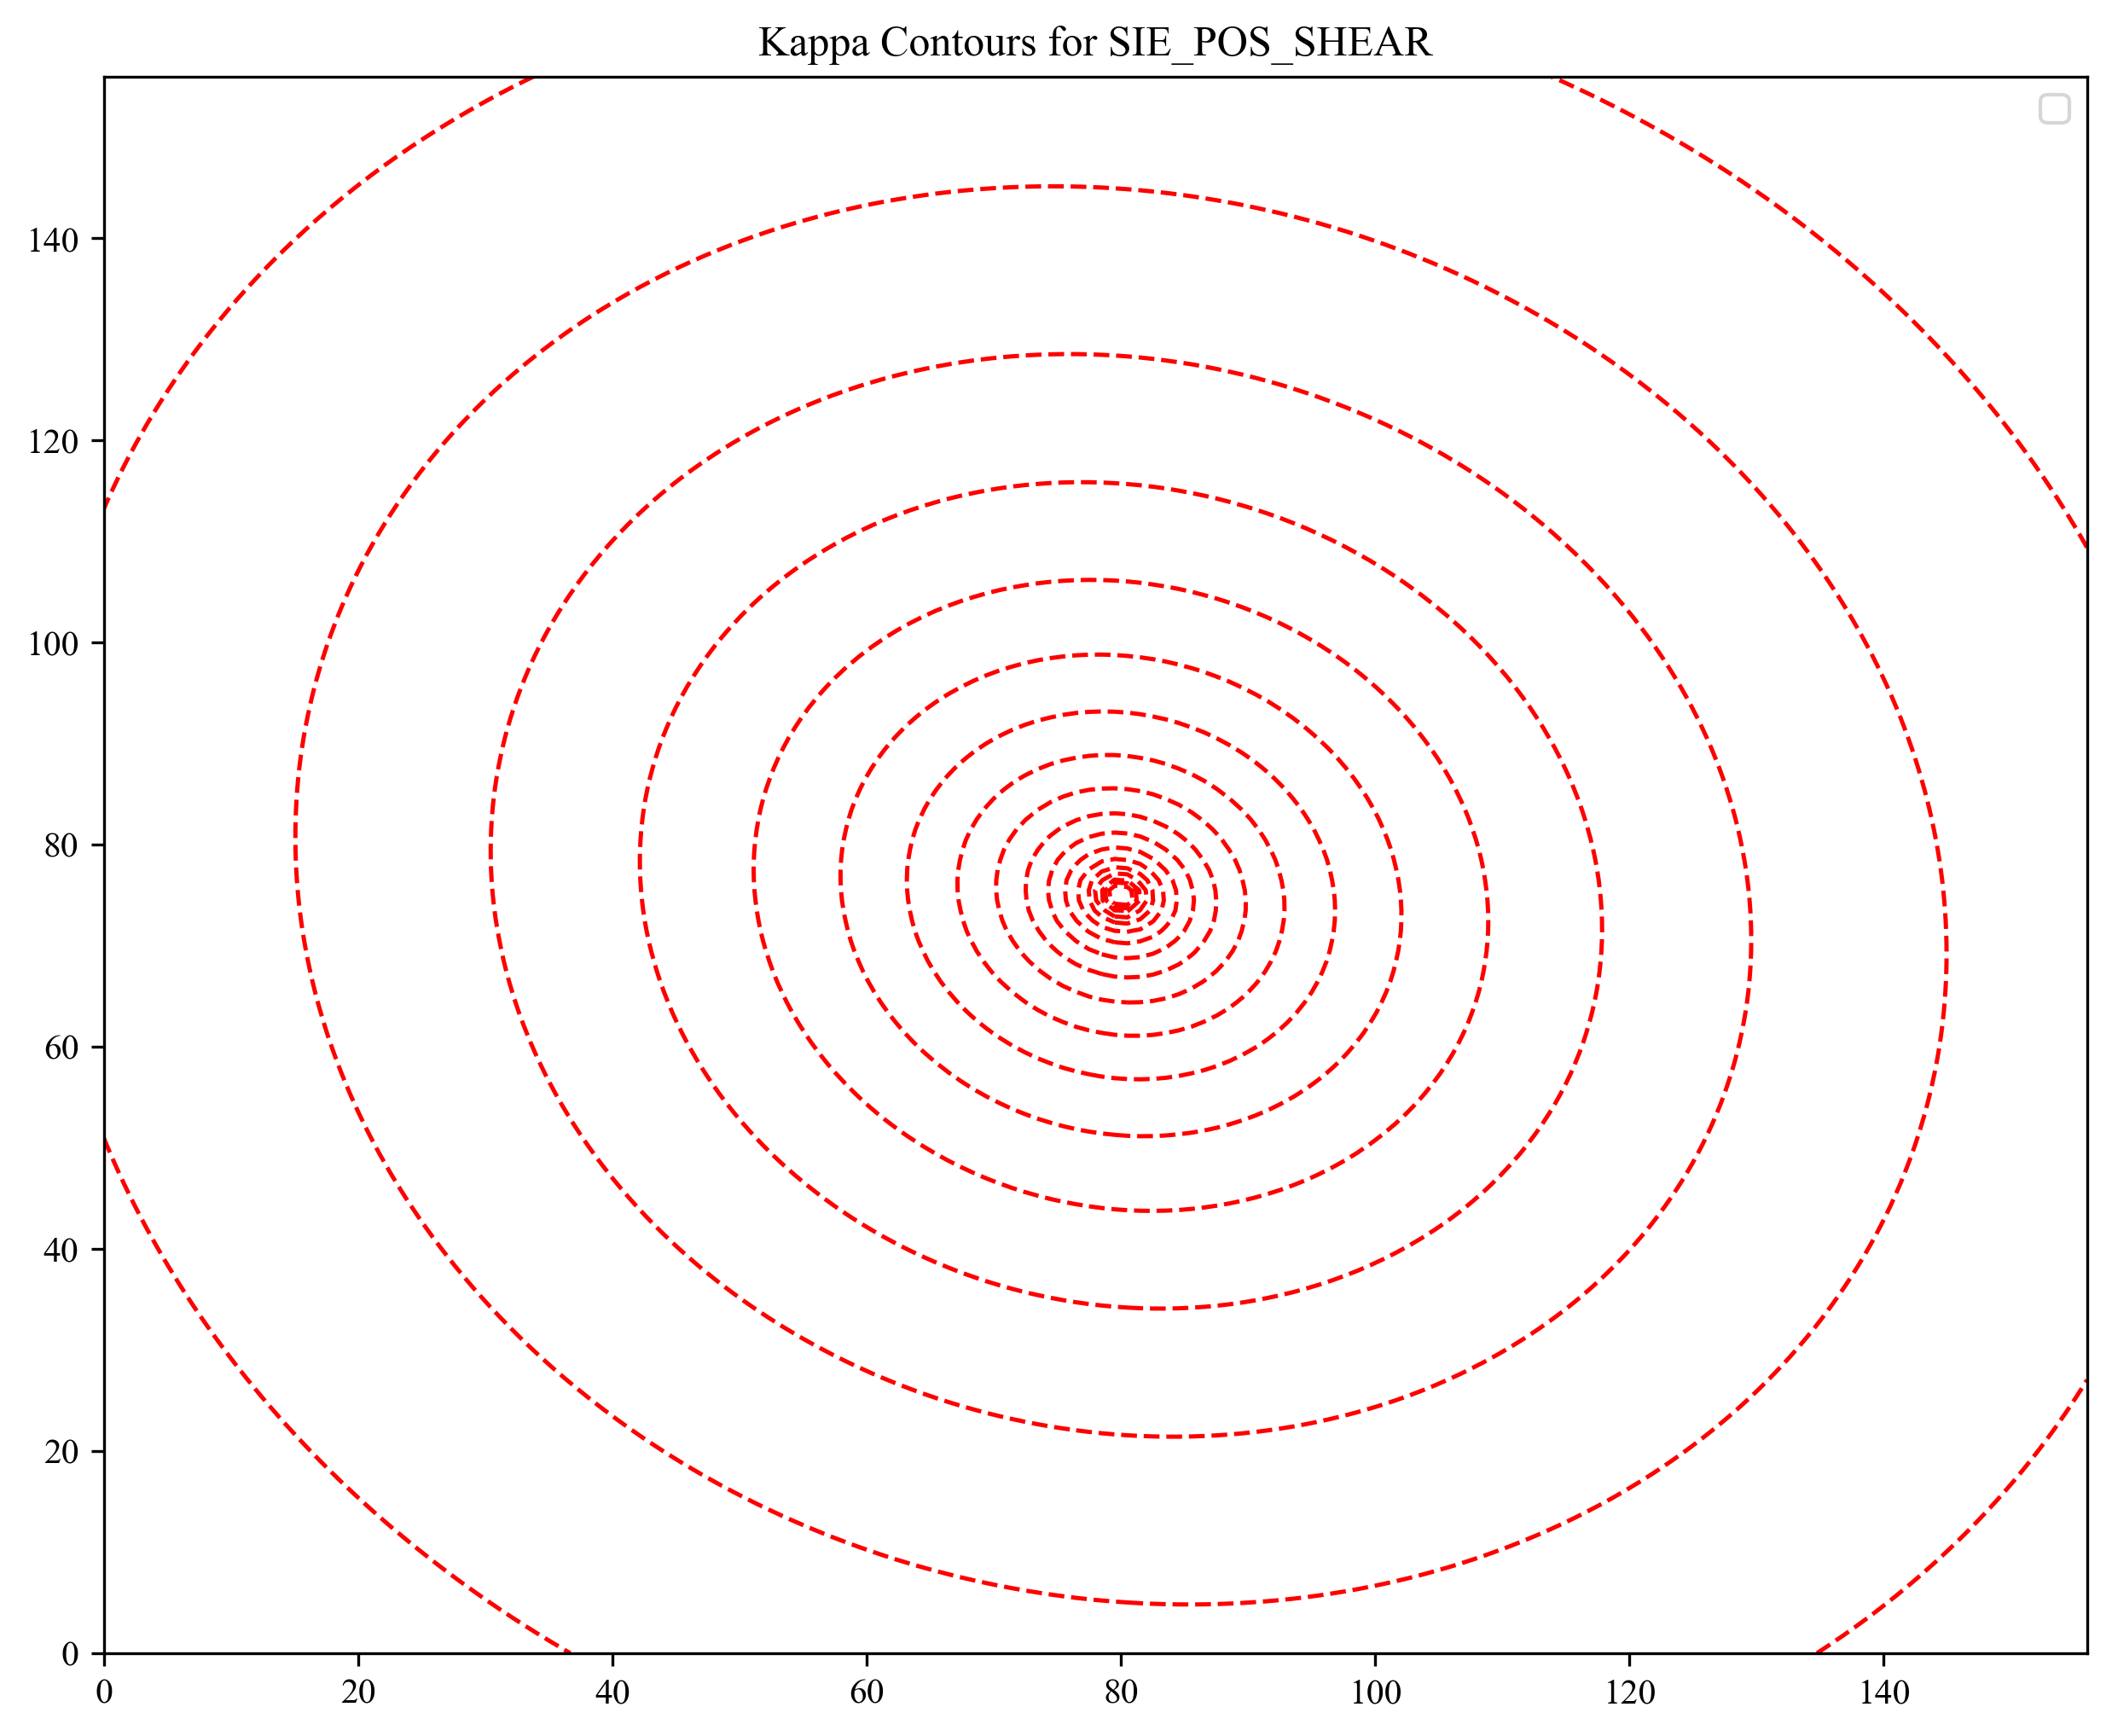

In [211]:
norm = ImageNormalize(kappa, stretch=LogStretch())
plt.figure(figsize=(10, 8))
# plt.imshow(kappa, cmap='hot', norm=norm)
plt.gca().invert_yaxis()
# cbar = plt.colorbar(label=r'$\kappa$')
# cbar.set_label(r'$\kappa$', rotation=0, fontsize=12)

# Logarithmic levels for better distribution
levels = np.logspace(np.log10(kappa.min() + 1e-6), np.log10(kappa.max()), 20)  # Add a small offset to avoid log(0)
contour = plt.contour(
    kappa, 
    levels=levels, 
    colors='red', 
    linewidths=1.2, 
    linestyles='dashed',
    alpha=1,
    extent=[0, kappa.shape[1], 0, kappa.shape[0]],
)

# plt.clabel(contour, inline=True, fontsize=8, fmt='%1.2e', colors='cyan')
# plt.scatter(pred['x_plot'], pred['y_plot'], c='white', s=70, label='Predicted Positions', marker='x')
# plt.scatter(plot_obs['x'], plot_obs['y'], c='blue', s=30, label='Observed Positions', marker='o')
# plt.scatter(crit_curves['1'], crit_curves['2'], c='yellow', s=5, label='Critical Curves', marker='o')
# plt.scatter(crit_curves['3'], crit_curves['4'], c='yellow', s=5, marker='o')
# plt.scatter(crit_curves['5'], crit_curves['6'], c='yellow', s=5, marker='o')
# plt.scatter(crit_curves['7'], crit_curves['8'], c='yellow', s=5, marker='o')
plt.title('Kappa Contours for ' + model_ver)
plt.legend()
plt.xlim(0, kappa.shape[1])
plt.ylim(0, kappa.shape[0])
# plt.savefig('kappa/Images/kappa_contours_' + model_ver + '.png', dpi=300, bbox_inches='tight')
plt.show()


In [212]:
lens_name = model_path
lens_name = lens_name + '/' + model_ver + '_macro'
lens_name = f'"{lens_name}"'
print(lens_name)

# Read original file
with open('Test/kappa_common.py', 'r') as f:
    py = f.readlines()

# Modify lines
new_lines = []
for line in py:
    if 'glafic.init(' in line:
        line = f"glafic.init(0.3, 0.7, -1.0, 0.7, {lens_name}, 20.0, 20.0, 21.56, 21.56, 0.01, 0.01, 1, verb = 0)\n"
    elif 'glafic.set_lens(1' in line:
        print('Found glafic.set_lens')
        line = f"glafic.set_lens(1, {df['Lens Name'][0]}, 0.261343256161012, {df['param1'][0]}, {df['param2'][0]}, {df['param3'][0]}, {df['param4'][0]}, {df['param5'][0]}, {df['param6'][0]}, {df['param7'][0]})\n"
    elif 'glafic.set_lens(2' in line:
        line = f"glafic.set_lens(2, {df['Lens Name'][1]}, 0.261343256161012, {df['param1'][1]}, {df['param2'][1]}, {df['param3'][1]}, {df['param4'][1]}, {df['param5'][1]}, {df['param6'][1]}, {df['param7'][1]})\n"
    elif 'glafic.set_lens(3' in line:
        line = f"glafic.set_lens(3, {df['Lens Name'][2]}, 0.261343256161012, {df['param1'][2]}, {df['param2'][2]}, {df['param3'][2]}, {df['param4'][2]}, {df['param5'][2]}, {df['param6'][2]}, {df['param7'][2]})\n"
    elif 'glafic.set_lens(4' in line:
        line = f"glafic.set_lens(4, {df['Lens Name'][3]}, 0.261343256161012, {df['param1'][3]}, {df['param2'][3]}, {df['param3'][3]}, {df['param4'][3]}, {df['param5'][3]}, {df['param6'][3]}, {df['param7'][3]})\n"
    elif 'glafic.set_point(' in line:
        print('Found glafic.set_point')
        if set_point_values is not None and len(set_point_values) == 3:
            line = f"glafic.set_point(1, 1.000, {set_point_values[1]}, {set_point_values[2]})\n"
        else:
            print("set_point_values is not set correctly.")
    new_lines.append(line)

# Write once, after all edits
with open('Test/kappa_common.py', 'w') as f:
    f.writelines(new_lines)

"Test/SIE+SHEAR/SIE_POS_SHEAR_macro"
Found glafic.set_lens
Found glafic.set_point


In [213]:
%run Test/kappa_common.py

######## writing lens properties
 zs = 1.000000e+00 
 output file name = Test/SIE+SHEAR/SIE_POS_SHEAR_macro_lens.fits 



In [214]:
# FITS File 
lens_name = lens_name.strip('"')
image = lens_name + '_lens' + '.fits'

hdu_list = fits.open(image)
hdu_list.info()

Filename: Test/SIE+SHEAR/SIE_POS_SHEAR_macro_lens.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      27   (156, 156, 8)   float32   


In [215]:
# Extract kappa 
kappa_macro = hdu_list[0].data[3]
kappa_macro = np.array(kappa_macro)
kappa_macro


array([[1.1458372, 1.1468792, 1.1479312, ..., 1.1653072, 1.1641089,
        1.1629192],
       [1.1466902, 1.1477498, 1.1488198, ..., 1.1663417, 1.1651194,
        1.1639066],
       [1.1475476, 1.148625 , 1.1497133, ..., 1.16738  , 1.1661335,
        1.164897 ],
       ...,
       [1.1546749, 1.1557466, 1.1568258, ..., 1.1484443, 1.1474278,
        1.1464196],
       [1.1537875, 1.1548396, 1.1558988, ..., 1.1475122, 1.1465137,
        1.1455231],
       [1.1529032, 1.1539361, 1.1549755, ..., 1.1465869, 1.145606 ,
        1.1446327]], dtype='>f4')

/var/folders/tm/964hg0yn70x0ddsqcj4bsf8r0000gn/T/ipykernel_77538/3824648672.py:28: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


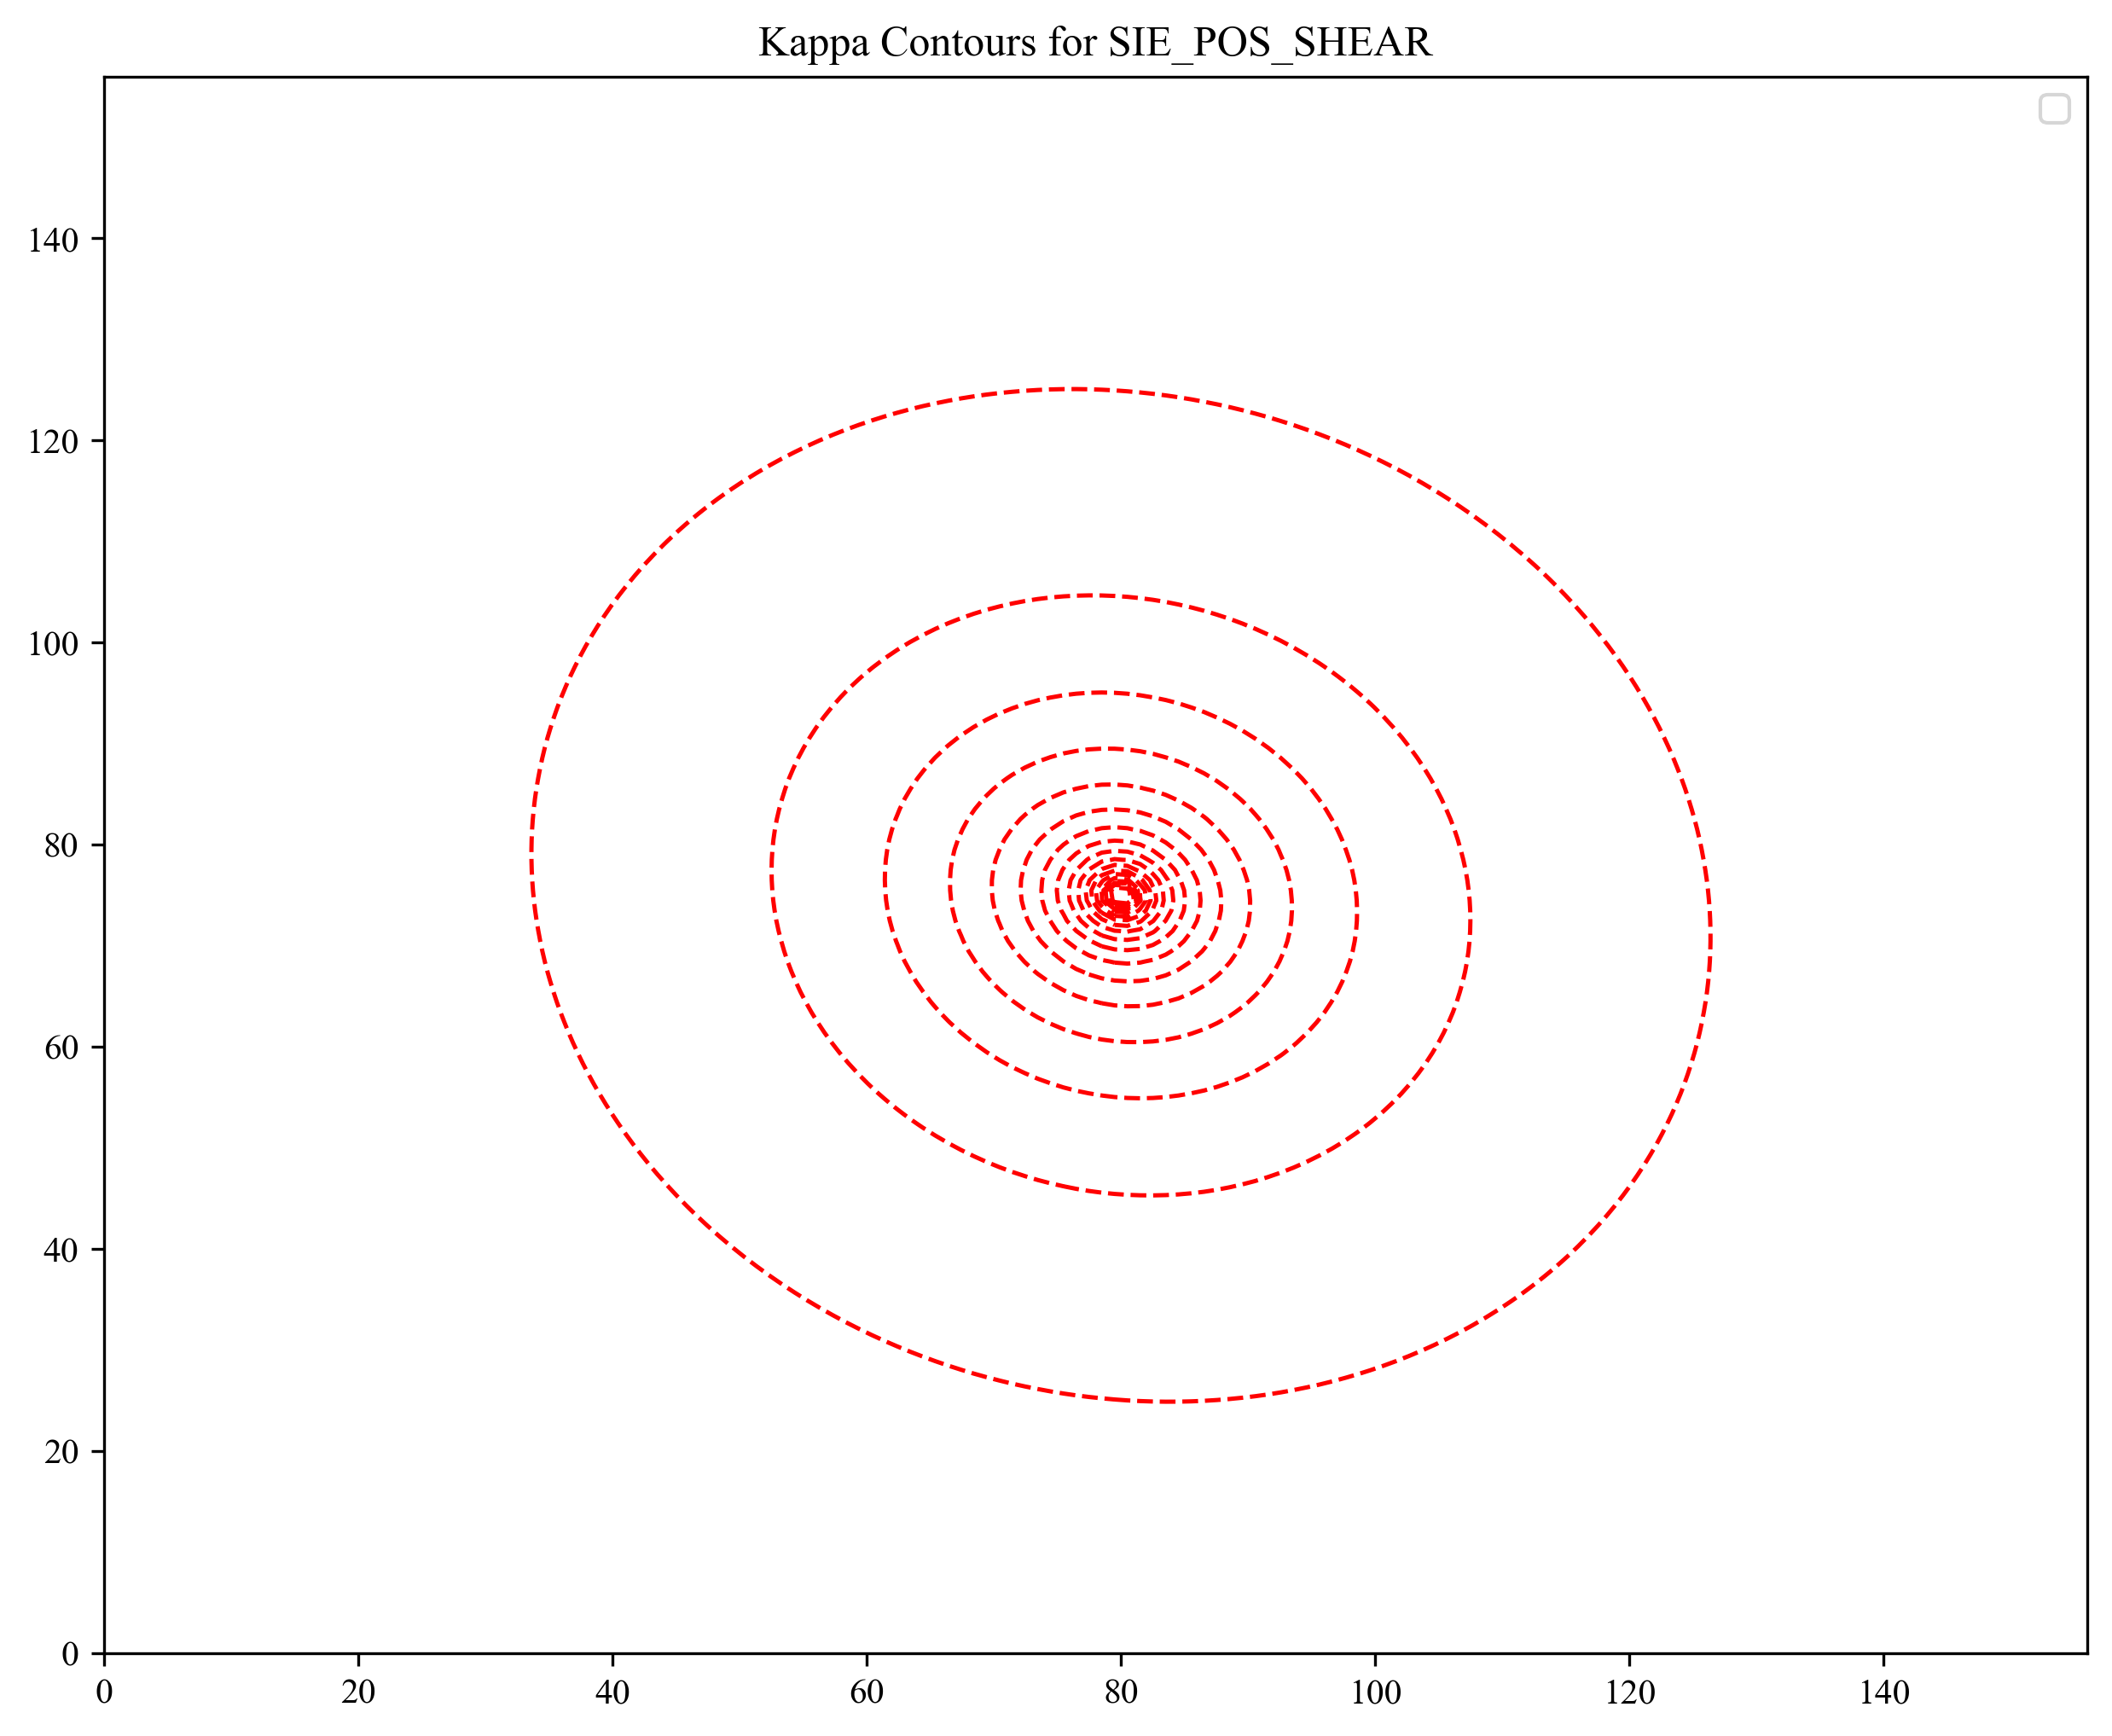

In [216]:
norm = ImageNormalize(kappa_macro, stretch=LogStretch())
plt.figure(figsize=(10, 8))
# plt.imshow(kappa, cmap='hot', norm=norm)
plt.gca().invert_yaxis()
# cbar = plt.colorbar(label=r'$\kappa$')
# cbar.set_label(r'$\kappa$', rotation=0, fontsize=12)

# Logarithmic levels for better distribution
levels = np.logspace(np.log10(kappa_macro.min() + 1e-6), np.log10(kappa_macro.max()), 20)  # Add a small offset to avoid log(0)
contour = plt.contour(
    kappa_macro, 
    levels=levels, 
    colors='red', 
    linewidths=1.2, 
    linestyles='dashed',
    alpha=1,
    extent=[0, kappa_macro.shape[1], 0, kappa_macro.shape[0]],
)

# plt.clabel(contour, inline=True, fontsize=8, fmt='%1.2e', colors='cyan')
# plt.scatter(pred['x_plot'], pred['y_plot'], c='white', s=70, label='Predicted Positions', marker='x')
# plt.scatter(plot_obs['x'], plot_obs['y'], c='blue', s=30, label='Observed Positions', marker='o')
# plt.scatter(crit_curves['1'], crit_curves['2'], c='yellow', s=5, label='Critical Curves', marker='o')
# plt.scatter(crit_curves['3'], crit_curves['4'], c='yellow', s=5, marker='o')
# plt.scatter(crit_curves['5'], crit_curves['6'], c='yellow', s=5, marker='o')
# plt.scatter(crit_curves['7'], crit_curves['8'], c='yellow', s=5, marker='o')
plt.title('Kappa Contours for ' + model_ver)
plt.legend()
plt.xlim(0, kappa_macro.shape[1])
plt.ylim(0, kappa_macro.shape[0])
# plt.savefig('kappa/Images/kappa_contours_' + model_ver + '.png', dpi=300, bbox_inches='tight')
plt.show()


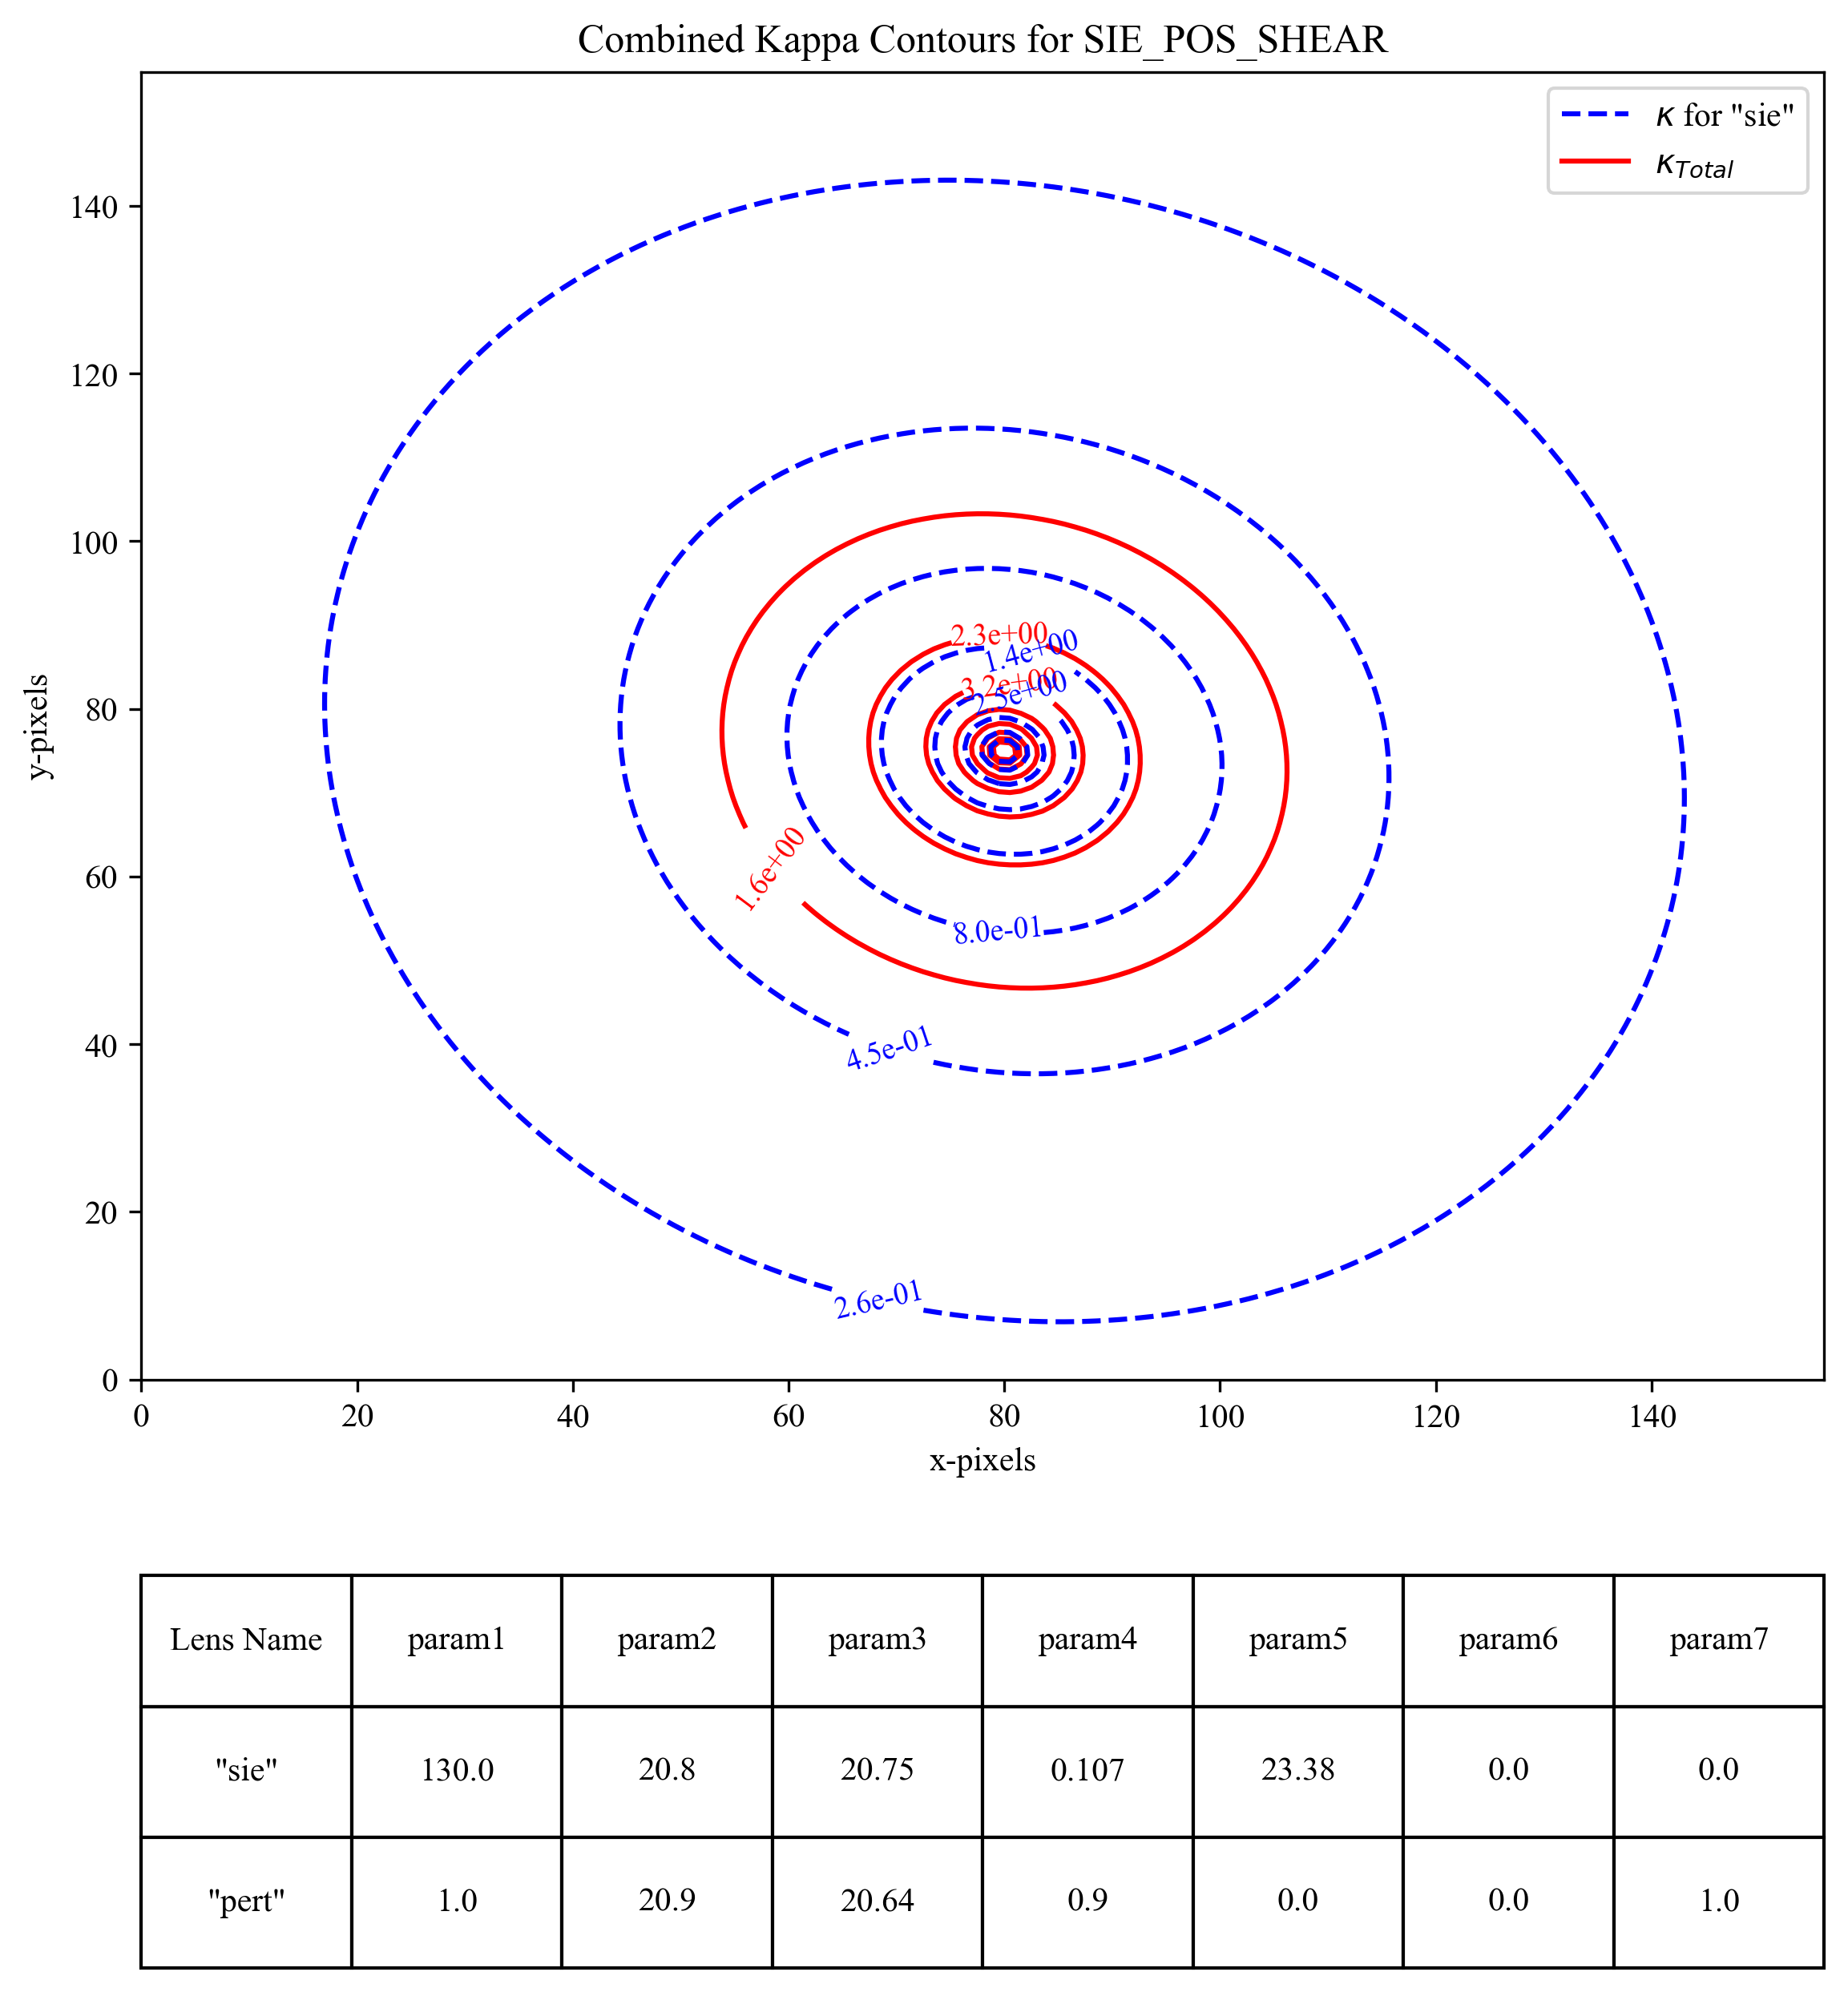

In [241]:
from IPython.display import display

# --- 1. Set up the Figure and Axes ---
plt.figure(figsize=(10, 8))
ax = plt.gca()
ax.invert_yaxis()


# --- 2. Plot the first set of contours for kappa_macro ---
levels_macro = np.logspace(
    np.log10(kappa_macro.min() + 1e-6),
    np.log10(kappa_macro.max()),
    10
)
contour_macro = ax.contour(
    kappa_macro,
    levels=levels_macro,
    colors='red',
    linewidths=1.5,
    linestyles='solid',
    extent=[0, kappa_macro.shape[1], 0, kappa_macro.shape[0]],
)
# --- ADD LABELS for the 'kappa_macro' contours ---
ax.clabel(
    contour_macro,
    levels=levels_macro[::1],  # Label every 3rd contour line to avoid clutter
    inline=True,               # Place labels inside the contour line
    fontsize=9,
    fmt='%1.1e',               # Format labels in scientific notation
    colors='red'               # Match label color to the line color
)


# --- 3. Plot the second set of contours for kappa ---
levels_total = np.logspace(
    np.log10(kappa.min() + 1e-6),
    np.log10(kappa.max()),
    10
)
contour_total = ax.contour(
    kappa,
    levels=levels_total,
    colors='blue',
    linewidths=1.5,
    linestyles='dashed',
    extent=[0, kappa.shape[1], 0, kappa.shape[0]],
)
# --- ADD LABELS for the 'kappa' contours ---
ax.clabel(
    contour_total,
    levels=levels_total[::1],  # Label every 3rd contour line
    inline=True,
    fontsize=9,
    fmt='%1.1e',
    colors='blue'
)


# --- 4. Finalize the Plot ---
legend_elements = [
    Line2D([0], [0], color='blue', lw=1.5, linestyle='dashed', label=r'$\kappa$ for ' + df['Lens Name'][i]),
    Line2D([0], [0], color='red', lw=1.5, linestyle='solid', label=r'$\kappa_{Total}$')
]

ax.set_title('Combined Kappa Contours for ' + model_ver)
ax.legend(handles=legend_elements)
ax.set_xlim(0, kappa.shape[1])
ax.set_ylim(0, kappa.shape[0])
ax.set_xlabel("x-pixels")
ax.set_ylabel("y-pixels")


# Convert DataFrame to string values for display
cell_text = df.values.astype(str)
col_labels = df.columns

# Add the table below the plot
the_table = ax.table(
    cellText=cell_text,
    colLabels=col_labels,
    loc='bottom',
    cellLoc='center',
    bbox=[0.0, -0.45, 1, 0.3]  # [left, bottom, width, height]
)
the_table.auto_set_font_size(False)
the_table.set_fontsize(10)
plt.subplots_adjust(left=0.2, bottom=0.2)

# plt.savefig('kappa/Images/kappa_contours_combined_' + model_ver + '.png', dpi=300, bbox_inches='tight')
plt.show()